# All numeric parameters calculates to find the best features

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Don't forget to use `ml_env` environment
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.feature_selection import SequentialFeatureSelector


In [2]:
# cleaning function when reading new files and set display in the notebook outputs
pd.set_option('display.max_columns', 50)

def clear_cols(s):
    return s.strip().replace(" ","_")

In [3]:
inpatient_path   = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train_Inpatientdata-1542865627584.csv'
outpatient_path  = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train_Outpatientdata-1542865627584.csv'
train_path       = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train-1542865627584.csv'
beneficiary_path = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train_Beneficiarydata-1542865627584.csv'
# path = '/GitHub Projects/MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis'
# /GitHub Projects/MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis
# read inpatient outpatient and train files data
inpatient  = pd.read_csv(inpatient_path).rename(columns=clear_cols)
outpatient = pd.read_csv(outpatient_path).rename(columns=clear_cols)
train      = pd.read_csv(train_path).rename(columns=clear_cols)
bene       = pd.read_csv(beneficiary_path).rename(columns=clear_cols)

In [4]:
train.sample()

,Provider,PotentialFraud
3509,PRV55404,No


In [5]:
inpatient.sample()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
18391,BENE78518,CLM40999,2009-03-03,2009-03-18,PRV57307,8000,PHY339384,NaN,NaN,2009-03-03,78079,1068.0,2009-03-18,880,29634,7999,3090,2768,3051,29570,30470,29410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
outpatient.sample()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode
509013,BENE156628,CLM125418,2009-01-07,2009-01-07,PRV55059,50,PHY338918,NaN,PHY338918,79029,4011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN


In [7]:
# Select only numeric columns
numeric_cols = inpatient.select_dtypes(include=['number']).columns.tolist()

# Display the numeric columns
print("Inpatient Numeric Columns:", numeric_cols)


Inpatient Numeric Columns: ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5', 'ClmProcedureCode_6']


In [8]:
df = inpatient.groupby('Provider').agg(
    IPInscClaimAmtReimbursedNunique = ('InscClaimAmtReimbursed', 'nunique'),
    IPInscClaimAmtReimbursedMean = ('InscClaimAmtReimbursed', 'mean'),
    IPInscClaimAmtReimbursedStd = ('InscClaimAmtReimbursed', 'std'),
    IPInscClaimAmtReimbursedSum = ('InscClaimAmtReimbursed', 'sum'),

    IPDeductibleAmtPaidMean = ('DeductibleAmtPaid', 'mean'),
    IPDeductibleAmtPaidStd = ('DeductibleAmtPaid', 'std'),
    IPDeductibleAmtPaidSum = ('DeductibleAmtPaid', 'sum'),

    IPClmProcedureCode_1Nunique = ('ClmProcedureCode_1', 'nunique'),
    IPClmProcedureCode_1Count = ('ClmProcedureCode_1', 'count'),
    IPClmProcedureCode_2Nunique = ('ClmProcedureCode_2', 'nunique'),
    IPClmProcedureCode_2Count = ('ClmProcedureCode_2', 'count'),
    IPClmProcedureCode_3Nunique = ('ClmProcedureCode_3', 'nunique'),
    IPClmProcedureCode_3Count = ('ClmProcedureCode_3', 'count'),
    IPClmProcedureCode_4Nunique = ('ClmProcedureCode_4', 'nunique'),
    IPClmProcedureCode_4Count = ('ClmProcedureCode_4', 'count'),
    IPClmProcedureCode_5Nunique= ('ClmProcedureCode_5', 'nunique'),
    IPClmProcedureCode_5Count = ('ClmProcedureCode_5', 'count'),
    IPClmProcedureCode_6Nunique = ('ClmProcedureCode_6', 'nunique'),
    IPClmProcedureCode_6Count = ('ClmProcedureCode_6', 'count')
).reset_index()
df.sample(3)

,Provider,IPInscClaimAmtReimbursedNunique,IPInscClaimAmtReimbursedMean,IPInscClaimAmtReimbursedStd,IPInscClaimAmtReimbursedSum,IPDeductibleAmtPaidMean,IPDeductibleAmtPaidStd,IPDeductibleAmtPaidSum,IPClmProcedureCode_1Nunique,IPClmProcedureCode_1Count,IPClmProcedureCode_2Nunique,IPClmProcedureCode_2Count,IPClmProcedureCode_3Nunique,IPClmProcedureCode_3Count,IPClmProcedureCode_4Nunique,IPClmProcedureCode_4Count,IPClmProcedureCode_5Nunique,IPClmProcedureCode_5Count,IPClmProcedureCode_6Nunique,IPClmProcedureCode_6Count
1207,PRV54846,8,12444.444444,10199.400854,112000,1068.0,0.0,9612.0,5,5,2,2,0,0,0,0,0,0,0,0
721,PRV53052,1,4000.000000,NaN,4000,1068.0,NaN,1068.0,1,1,0,0,0,0,0,0,0,0,0,0
1759,PRV56632,5,5571.428571,2699.206233,39000,1068.0,0.0,7476.0,5,5,1,1,0,0,0,0,0,0,0,0


In [9]:
# Select only numeric columns
numeric_cols = outpatient.select_dtypes(include=['number']).columns.tolist()

# Display the numeric columns
print("Inpatient Numeric Columns:", numeric_cols)


Inpatient Numeric Columns: ['InscClaimAmtReimbursed', 'ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5', 'ClmProcedureCode_6', 'DeductibleAmtPaid']


In [10]:
df_out = outpatient.groupby('Provider').agg(
    OPInscClaimAmtReimbursedNunique = ('InscClaimAmtReimbursed', 'nunique'),
    OPInscClaimAmtReimbursedMean = ('InscClaimAmtReimbursed', 'mean'),
    OPInscClaimAmtReimbursedStd = ('InscClaimAmtReimbursed', 'std'),
    OPInscClaimAmtReimbursedSum = ('InscClaimAmtReimbursed', 'sum'),
    OPDeductibleAmtPaidMean = ('DeductibleAmtPaid', 'mean'),
    OPDeductibleAmtPaidStd = ('DeductibleAmtPaid', 'std'),
    OPDeductibleAmtPaidSum = ('DeductibleAmtPaid', 'sum'),
    OPClmProcedureCode_1Nunique = ('ClmProcedureCode_1', 'nunique'),
    OPClmProcedureCode_1Count = ('ClmProcedureCode_1', 'count'),
    OPClmProcedureCode_2Nunique = ('ClmProcedureCode_2', 'nunique'),
    OPClmProcedureCode_2Count = ('ClmProcedureCode_2', 'count'),
    OPClmProcedureCode_3Nunique = ('ClmProcedureCode_3', 'nunique'),
    OPClmProcedureCode_3Count = ('ClmProcedureCode_3', 'count'),
    OPClmProcedureCode_4Nunique = ('ClmProcedureCode_4', 'nunique'),
    OPClmProcedureCode_4Count = ('ClmProcedureCode_4', 'count'),
    OPClmProcedureCode_5Nunique= ('ClmProcedureCode_5', 'nunique'),
    OPClmProcedureCode_5Count = ('ClmProcedureCode_5', 'count'),
    OPClmProcedureCode_6Nunique = ('ClmProcedureCode_6', 'nunique'),
    OPClmProcedureCode_6Count = ('ClmProcedureCode_6', 'count')
).reset_index()
df_out.sample(3)

,Provider,OPInscClaimAmtReimbursedNunique,OPInscClaimAmtReimbursedMean,OPInscClaimAmtReimbursedStd,OPInscClaimAmtReimbursedSum,OPDeductibleAmtPaidMean,OPDeductibleAmtPaidStd,OPDeductibleAmtPaidSum,OPClmProcedureCode_1Nunique,OPClmProcedureCode_1Count,OPClmProcedureCode_2Nunique,OPClmProcedureCode_2Count,OPClmProcedureCode_3Nunique,OPClmProcedureCode_3Count,OPClmProcedureCode_4Nunique,OPClmProcedureCode_4Count,OPClmProcedureCode_5Nunique,OPClmProcedureCode_5Count,OPClmProcedureCode_6Nunique,OPClmProcedureCode_6Count
3459,PRV55648,2,40.000000,28.284271,80,50.0,70.710678,100,0,0,0,0,0,0,0,0,0,0,0,0
4081,PRV56490,2,56.666667,40.414519,170,0.0,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0
3524,PRV55744,2,40.000000,42.426407,80,0.0,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
df_out.columns

Index(['Provider', 'OPInscClaimAmtReimbursedNunique',
       'OPInscClaimAmtReimbursedMean', 'OPInscClaimAmtReimbursedStd',
       'OPInscClaimAmtReimbursedSum', 'OPDeductibleAmtPaidMean',
       'OPDeductibleAmtPaidStd', 'OPDeductibleAmtPaidSum',
       'OPClmProcedureCode_1Nunique', 'OPClmProcedureCode_1Count',
       'OPClmProcedureCode_2Nunique', 'OPClmProcedureCode_2Count',
       'OPClmProcedureCode_3Nunique', 'OPClmProcedureCode_3Count',
       'OPClmProcedureCode_4Nunique', 'OPClmProcedureCode_4Count',
       'OPClmProcedureCode_5Nunique', 'OPClmProcedureCode_5Count',
       'OPClmProcedureCode_6Nunique', 'OPClmProcedureCode_6Count'],
      dtype='object')

In [12]:
# Then merge with fraud labels
provider_claims = pd.merge(
    df,
    df_out,
    on='Provider',
    how='outer'
).fillna(0)  # Fill NaN with 0 for providers with only one type of claims
provider_claims

,Provider,IPInscClaimAmtReimbursedNunique,IPInscClaimAmtReimbursedMean,IPInscClaimAmtReimbursedStd,IPInscClaimAmtReimbursedSum,IPDeductibleAmtPaidMean,IPDeductibleAmtPaidStd,IPDeductibleAmtPaidSum,IPClmProcedureCode_1Nunique,IPClmProcedureCode_1Count,IPClmProcedureCode_2Nunique,IPClmProcedureCode_2Count,IPClmProcedureCode_3Nunique,IPClmProcedureCode_3Count,IPClmProcedureCode_4Nunique,IPClmProcedureCode_4Count,IPClmProcedureCode_5Nunique,IPClmProcedureCode_5Count,IPClmProcedureCode_6Nunique,IPClmProcedureCode_6Count,OPInscClaimAmtReimbursedNunique,OPInscClaimAmtReimbursedMean,OPInscClaimAmtReimbursedStd,OPInscClaimAmtReimbursedSum,OPDeductibleAmtPaidMean,OPDeductibleAmtPaidStd,OPDeductibleAmtPaidSum,OPClmProcedureCode_1Nunique,OPClmProcedureCode_1Count,OPClmProcedureCode_2Nunique,OPClmProcedureCode_2Count,OPClmProcedureCode_3Nunique,OPClmProcedureCode_3Count,OPClmProcedureCode_4Nunique,OPClmProcedureCode_4Count,OPClmProcedureCode_5Nunique,OPClmProcedureCode_5Count,OPClmProcedureCode_6Nunique,OPClmProcedureCode_6Count
0,PRV51001,5.0,19400.000000,18352.111595,97000.0,1068.0,0.0,5340.0,2.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,382.000000,422.817617,7640.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,PRV51003,18.0,9241.935484,8513.606244,573000.0,1068.0,0.0,66216.0,32.0,39.0,7.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,466.714286,821.364579,32670.0,1.000000,8.366600,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,PRV51004,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,350.134228,689.963754,52170.0,2.080537,11.166744,310.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,PRV51005,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.0,241.124464,491.556392,280910.0,3.175966,17.026584,3700.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,PRV51007,3.0,6333.333333,3511.884584,19000.0,1068.0,0.0,3204.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,213.188406,447.231657,14710.0,0.869565,6.121114,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,PRV57759,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,380.000000,820.880286,10640.0,4.642857,18.354966,130.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5406,PRV57760,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,216.818182,309.998254,4770.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5407,PRV57761,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,225.243902,418.366092,18470.0,4.512195,16.714926,370.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5408,PRV57762,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1900.000000,0.000000,1900.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# Then merge with fraud labels
final_df = pd.merge(
    provider_claims,
    train[['Provider', 'PotentialFraud']],
    on='Provider',
    how='outer'
).fillna(0)  # Fill NaN with 0 for providers with only one type of claims
final_df

,Provider,IPInscClaimAmtReimbursedNunique,IPInscClaimAmtReimbursedMean,IPInscClaimAmtReimbursedStd,IPInscClaimAmtReimbursedSum,IPDeductibleAmtPaidMean,IPDeductibleAmtPaidStd,IPDeductibleAmtPaidSum,IPClmProcedureCode_1Nunique,IPClmProcedureCode_1Count,IPClmProcedureCode_2Nunique,IPClmProcedureCode_2Count,IPClmProcedureCode_3Nunique,IPClmProcedureCode_3Count,IPClmProcedureCode_4Nunique,IPClmProcedureCode_4Count,IPClmProcedureCode_5Nunique,IPClmProcedureCode_5Count,IPClmProcedureCode_6Nunique,IPClmProcedureCode_6Count,OPInscClaimAmtReimbursedNunique,OPInscClaimAmtReimbursedMean,OPInscClaimAmtReimbursedStd,OPInscClaimAmtReimbursedSum,OPDeductibleAmtPaidMean,OPDeductibleAmtPaidStd,OPDeductibleAmtPaidSum,OPClmProcedureCode_1Nunique,OPClmProcedureCode_1Count,OPClmProcedureCode_2Nunique,OPClmProcedureCode_2Count,OPClmProcedureCode_3Nunique,OPClmProcedureCode_3Count,OPClmProcedureCode_4Nunique,OPClmProcedureCode_4Count,OPClmProcedureCode_5Nunique,OPClmProcedureCode_5Count,OPClmProcedureCode_6Nunique,OPClmProcedureCode_6Count,PotentialFraud
0,PRV51001,5.0,19400.000000,18352.111595,97000.0,1068.0,0.0,5340.0,2.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,382.000000,422.817617,7640.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No
1,PRV51003,18.0,9241.935484,8513.606244,573000.0,1068.0,0.0,66216.0,32.0,39.0,7.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,466.714286,821.364579,32670.0,1.000000,8.366600,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Yes
2,PRV51004,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,350.134228,689.963754,52170.0,2.080537,11.166744,310.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No
3,PRV51005,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.0,241.124464,491.556392,280910.0,3.175966,17.026584,3700.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Yes
4,PRV51007,3.0,6333.333333,3511.884584,19000.0,1068.0,0.0,3204.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,213.188406,447.231657,14710.0,0.869565,6.121114,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,PRV57759,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,380.000000,820.880286,10640.0,4.642857,18.354966,130.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No
5406,PRV57760,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,216.818182,309.998254,4770.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No
5407,PRV57761,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,225.243902,418.366092,18470.0,4.512195,16.714926,370.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No
5408,PRV57762,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1900.000000,0.000000,1900.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No


In [14]:
# preper the binary column for modeling ("1,0" instead of "Yes" and "No")
final_df['PotentialFraud'] = final_df['PotentialFraud'].map({'Yes': 1, 'No': 0})
final_df

,Provider,IPInscClaimAmtReimbursedNunique,IPInscClaimAmtReimbursedMean,IPInscClaimAmtReimbursedStd,IPInscClaimAmtReimbursedSum,IPDeductibleAmtPaidMean,IPDeductibleAmtPaidStd,IPDeductibleAmtPaidSum,IPClmProcedureCode_1Nunique,IPClmProcedureCode_1Count,IPClmProcedureCode_2Nunique,IPClmProcedureCode_2Count,IPClmProcedureCode_3Nunique,IPClmProcedureCode_3Count,IPClmProcedureCode_4Nunique,IPClmProcedureCode_4Count,IPClmProcedureCode_5Nunique,IPClmProcedureCode_5Count,IPClmProcedureCode_6Nunique,IPClmProcedureCode_6Count,OPInscClaimAmtReimbursedNunique,OPInscClaimAmtReimbursedMean,OPInscClaimAmtReimbursedStd,OPInscClaimAmtReimbursedSum,OPDeductibleAmtPaidMean,OPDeductibleAmtPaidStd,OPDeductibleAmtPaidSum,OPClmProcedureCode_1Nunique,OPClmProcedureCode_1Count,OPClmProcedureCode_2Nunique,OPClmProcedureCode_2Count,OPClmProcedureCode_3Nunique,OPClmProcedureCode_3Count,OPClmProcedureCode_4Nunique,OPClmProcedureCode_4Count,OPClmProcedureCode_5Nunique,OPClmProcedureCode_5Count,OPClmProcedureCode_6Nunique,OPClmProcedureCode_6Count,PotentialFraud
0,PRV51001,5.0,19400.000000,18352.111595,97000.0,1068.0,0.0,5340.0,2.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,382.000000,422.817617,7640.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,PRV51003,18.0,9241.935484,8513.606244,573000.0,1068.0,0.0,66216.0,32.0,39.0,7.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,466.714286,821.364579,32670.0,1.000000,8.366600,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,PRV51004,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,350.134228,689.963754,52170.0,2.080537,11.166744,310.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,PRV51005,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.0,241.124464,491.556392,280910.0,3.175966,17.026584,3700.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,PRV51007,3.0,6333.333333,3511.884584,19000.0,1068.0,0.0,3204.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,213.188406,447.231657,14710.0,0.869565,6.121114,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,PRV57759,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,380.000000,820.880286,10640.0,4.642857,18.354966,130.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5406,PRV57760,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,216.818182,309.998254,4770.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5407,PRV57761,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,225.243902,418.366092,18470.0,4.512195,16.714926,370.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5408,PRV57762,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1900.000000,0.000000,1900.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [15]:
final_df.columns

Index(['Provider', 'IPInscClaimAmtReimbursedNunique',
       'IPInscClaimAmtReimbursedMean', 'IPInscClaimAmtReimbursedStd',
       'IPInscClaimAmtReimbursedSum', 'IPDeductibleAmtPaidMean',
       'IPDeductibleAmtPaidStd', 'IPDeductibleAmtPaidSum',
       'IPClmProcedureCode_1Nunique', 'IPClmProcedureCode_1Count',
       'IPClmProcedureCode_2Nunique', 'IPClmProcedureCode_2Count',
       'IPClmProcedureCode_3Nunique', 'IPClmProcedureCode_3Count',
       'IPClmProcedureCode_4Nunique', 'IPClmProcedureCode_4Count',
       'IPClmProcedureCode_5Nunique', 'IPClmProcedureCode_5Count',
       'IPClmProcedureCode_6Nunique', 'IPClmProcedureCode_6Count',
       'OPInscClaimAmtReimbursedNunique', 'OPInscClaimAmtReimbursedMean',
       'OPInscClaimAmtReimbursedStd', 'OPInscClaimAmtReimbursedSum',
       'OPDeductibleAmtPaidMean', 'OPDeductibleAmtPaidStd',
       'OPDeductibleAmtPaidSum', 'OPClmProcedureCode_1Nunique',
       'OPClmProcedureCode_1Count', 'OPClmProcedureCode_2Nunique',
       'OPClmPro

In [16]:
X = final_df[['IPInscClaimAmtReimbursedNunique',
       'IPInscClaimAmtReimbursedMean', 'IPInscClaimAmtReimbursedStd',
       'IPInscClaimAmtReimbursedSum', 'IPDeductibleAmtPaidMean',
       'IPDeductibleAmtPaidStd', 'IPDeductibleAmtPaidSum',
       'IPClmProcedureCode_1Nunique', 'IPClmProcedureCode_1Count',
       'IPClmProcedureCode_2Nunique', 'IPClmProcedureCode_2Count',
       'IPClmProcedureCode_3Nunique', 'IPClmProcedureCode_3Count',
       'IPClmProcedureCode_4Nunique', 'IPClmProcedureCode_4Count',
       'IPClmProcedureCode_5Nunique', 'IPClmProcedureCode_5Count',
       'IPClmProcedureCode_6Nunique', 'IPClmProcedureCode_6Count',
       'OPInscClaimAmtReimbursedNunique', 'OPInscClaimAmtReimbursedMean',
       'OPInscClaimAmtReimbursedStd', 'OPInscClaimAmtReimbursedSum',
       'OPDeductibleAmtPaidMean', 'OPDeductibleAmtPaidStd',
       'OPDeductibleAmtPaidSum', 'OPClmProcedureCode_1Nunique',
       'OPClmProcedureCode_1Count', 'OPClmProcedureCode_2Nunique',
       'OPClmProcedureCode_2Count', 'OPClmProcedureCode_3Nunique',
       'OPClmProcedureCode_3Count', 'OPClmProcedureCode_4Nunique',
       'OPClmProcedureCode_4Count', 'OPClmProcedureCode_5Nunique',
       'OPClmProcedureCode_5Count', 'OPClmProcedureCode_6Nunique',
       'OPClmProcedureCode_6Count']]

y = final_df['PotentialFraud']

In [17]:
y

0       0
1       1
2       0
3       1
4       0
       ..
5405    0
5406    0
5407    0
5408    0
5409    0
Name: PotentialFraud, Length: 5410, dtype: int64

In [18]:
# # Split data
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

# # 2. Scale the features (standardization: mean = 0, std = 1).
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)  # Fit on train, then transform
# X_test = scaler.transform(X_test)  # Transform test data using train's mean & std

# # Train Logistic Regression
# model = LogisticRegression(random_state=42)
# model.fit(X_train, y_train)

# # Predict and evaluate
# y_pred = model.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Logistic Regression Accuracy: {accuracy:.4f}")

In [19]:
# a short helper to get the relevant columns for the model features
final_df.columns

Index(['Provider', 'IPInscClaimAmtReimbursedNunique',
       'IPInscClaimAmtReimbursedMean', 'IPInscClaimAmtReimbursedStd',
       'IPInscClaimAmtReimbursedSum', 'IPDeductibleAmtPaidMean',
       'IPDeductibleAmtPaidStd', 'IPDeductibleAmtPaidSum',
       'IPClmProcedureCode_1Nunique', 'IPClmProcedureCode_1Count',
       'IPClmProcedureCode_2Nunique', 'IPClmProcedureCode_2Count',
       'IPClmProcedureCode_3Nunique', 'IPClmProcedureCode_3Count',
       'IPClmProcedureCode_4Nunique', 'IPClmProcedureCode_4Count',
       'IPClmProcedureCode_5Nunique', 'IPClmProcedureCode_5Count',
       'IPClmProcedureCode_6Nunique', 'IPClmProcedureCode_6Count',
       'OPInscClaimAmtReimbursedNunique', 'OPInscClaimAmtReimbursedMean',
       'OPInscClaimAmtReimbursedStd', 'OPInscClaimAmtReimbursedSum',
       'OPDeductibleAmtPaidMean', 'OPDeductibleAmtPaidStd',
       'OPDeductibleAmtPaidSum', 'OPClmProcedureCode_1Nunique',
       'OPClmProcedureCode_1Count', 'OPClmProcedureCode_2Nunique',
       'OPClmPro

In [20]:
# 
y = final_df['PotentialFraud']

In [21]:
# 1. Split
# Now we'll splpit the data into train and test, usually, 80% train in my case here.
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)


In [22]:
# 2. Scale the features (standardization: mean = 0, std = 1).
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit on train, then transform
X_test = scaler.transform(X_test)  # Transform test data using train's mean & std


In [23]:
# 3. Train a logistic regression model.
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)  # Fit model on training data

LogisticRegression(random_state=42)

In [24]:
# 4. Make predictions on the test set.
y_predict = model.predict(X_test)  # Outputs predicted class labels (0 or 1)

y_proba = model.predict_proba(X_test)[:, 1] # Outputs predicted class labels (0 or 1)


In [25]:
# Now it's time to create the confusion matrix.
# in sklearn, the setup for it is: TP is the bottom right, FN bottom left, TN top left and FP top right.
from sklearn.metrics import confusion_matrix
# Assuming y_test contains true labels and y_predict contains predicted labels
cm = confusion_matrix(y_test, y_predict)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[963  14]
 [ 63  42]]


In [26]:
# flatten the confusion matrix and break it down into four components.
TN, FP, FN, TP = cm.ravel()
# print('Confusion Matrix before manipulating by adding the threshold:\n')

# Calculating metrics
accuracy = accuracy_score(y_test, y_predict) # 2 ways to calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN) # Proportion of correct predictions
print(f'Accuracy: {accuracy:.2f}')
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
print(f'Precision: {precision:.2f}')
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f'Recall: {recall:.2f}')
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print(f'F1 Score: {f1_score:.2f}')

Accuracy: 0.93
Precision: 0.75
Recall: 0.40
F1 Score: 0.52


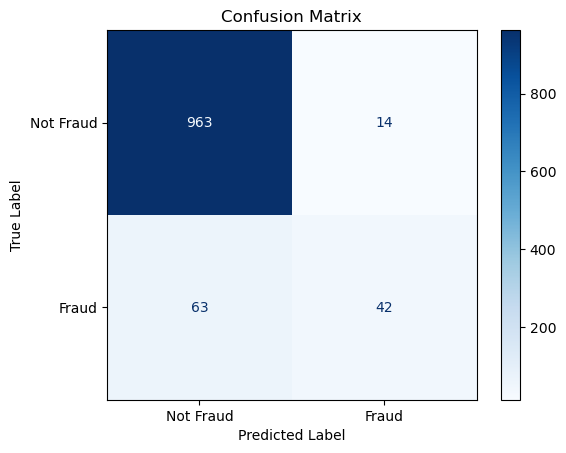

In [27]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Compute and display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

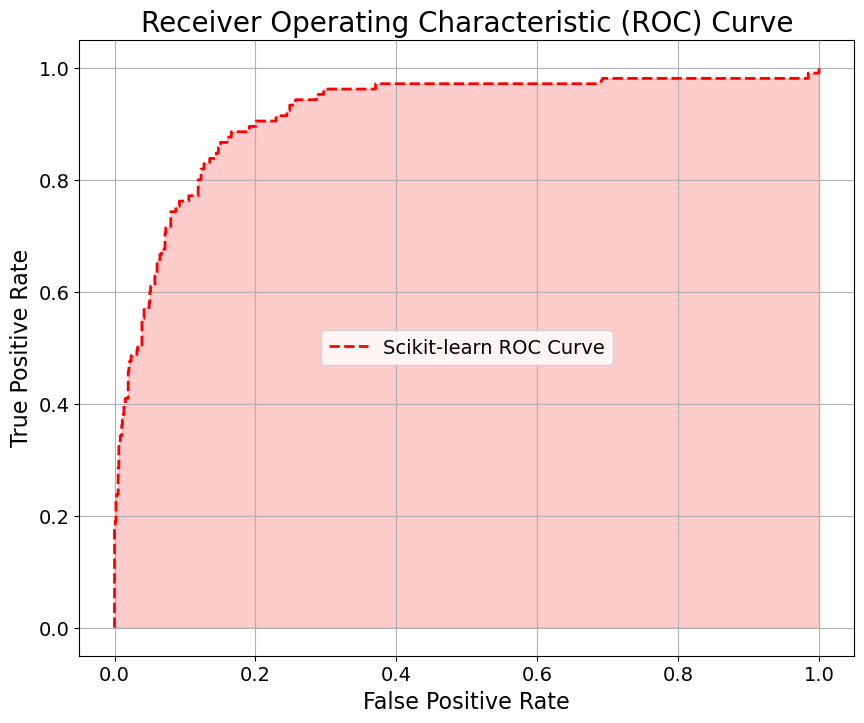

In [28]:
from sklearn.metrics import roc_curve

# Compare with scikit-learn's implementation
# Set up the figure first
fig, ax = plt.subplots(figsize=(10, 8))
# Compare with scikit-learn's implementation
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
# roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, 'r--', lw=2, label=f'Scikit-learn ROC Curve') #(AUC = {roc_auc:.2f})')
# Fill under the ROC curve
ax.fill_between(fpr, tpr, alpha=0.2, color='red')  # alpha=0.2 makes it somewhat transparent
# Add styling with larger fonts
ax.set_title('Receiver Operating Characteristic (ROC) Curve', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=14)
ax.grid(True)

In [29]:
from sklearn.metrics import auc
# Area Under Curve
auc(fpr, tpr)

np.float64(0.9167422137739435)

# This part suppose to help me to fine tune the best accuracy (which is not the most important now)

In [30]:
# Perform Sequential Feature Selector with n=1 and build on above code
from sklearn.feature_selection import SequentialFeatureSelector
# I can adjust the n_features_to_select: 1, to get the best feature, 
# 2 will give me more, but unnecessary combine them will give the bset results.
sfs = SequentialFeatureSelector(model, n_features_to_select=4)
sfs.fit(X_train, y_train)

SequentialFeatureSelector(estimator=LogisticRegression(random_state=42),
                          n_features_to_select=4)

In [31]:
selected_features = X.columns[sfs.get_support()].to_list()
print(f"Features selected by SFS: {selected_features}")

Features selected by SFS: ['IPInscClaimAmtReimbursedSum', 'IPDeductibleAmtPaidSum', 'IPClmProcedureCode_1Nunique', 'OPDeductibleAmtPaidSum']


### loooking for a better threshold to find better f1 score:

In [ ]:
# # Get predicted probabilities
# y_proba = model.predict_proba(X_test)[:, 1]

In [187]:
# precicions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

# f1_scores = 2 * (precicions * recalls) / (precicions + recalls)
# best_threshold = thresholds[f1_scores.argmax()]
# print(f"Optimal threshold based on F1-score: {best_threshold}")

Optimal threshold based on F1-score: 0.17042821773682973


In [188]:
# # apply the new best threshold to the predicted probabilities
# y_pred_custom = (y_proba >= best_threshold).astype(int)
# # Compute confusion matrix
# cm = confusion_matrix(y_test, y_pred_custom)
# print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[916  61]
 [ 35  70]]


In [ ]:
# 

In [189]:
# # Calculating metrics
# accuracy = accuracy_score(y_test, y_pred_custom) # 2 ways to calculate accuracy
# accuracy = (TP + TN) / (TP + TN + FP + FN) # Proportion of correct predictions
# print(f'Accuracy: {accuracy:.2f}')
# precision = TP / (TP + FP) if (TP + FP) != 0 else 0
# print(f'Precision: {precision:.2f}')
# recall = TP / (TP + FN) if (TP + FN) != 0 else 0
# print(f'Recall: {recall:.2f}')
# f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
# print(f'F1 Score: {f1_score:.2f}')

Accuracy: 0.93
Precision: 0.73
Recall: 0.39
F1 Score: 0.51


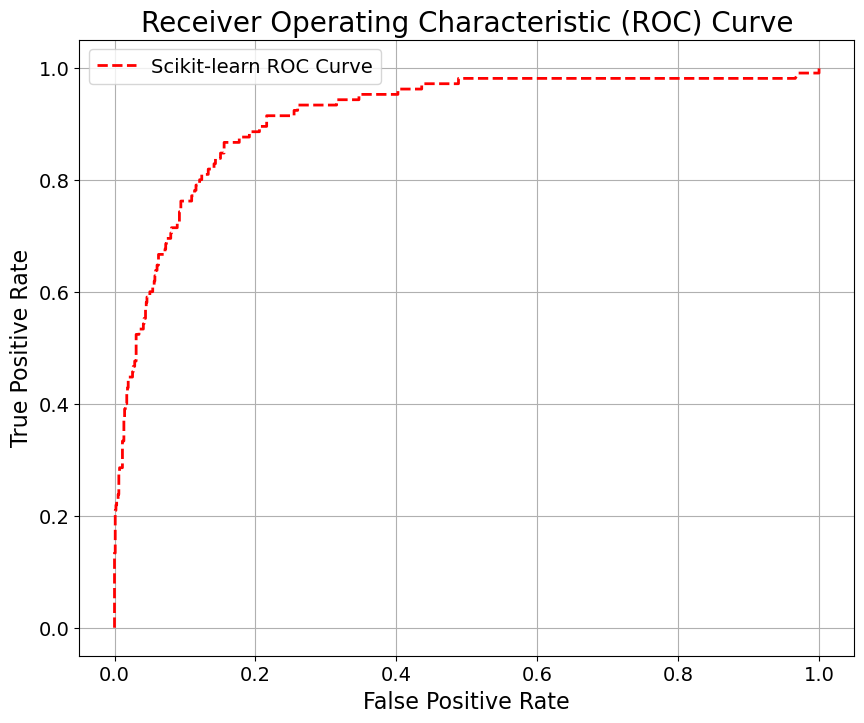

In [190]:
# from sklearn.metrics import roc_curve

# # Compare with scikit-learn's implementation
# # Set up the figure first
# fig, ax = plt.subplots(figsize=(10, 8))
# # Compare with scikit-learn's implementation
# fpr, tpr, thresholds = roc_curve(y_test, y_proba)
# # roc_auc = auc(fpr, tpr)
# ax.plot(fpr, tpr, 'r--', lw=2, label=f'Scikit-learn ROC Curve') #(AUC = {roc_auc:.2f})')
# # Add styling with larger fonts
# ax.set_title('Receiver Operating Characteristic (ROC) Curve', fontsize=20)
# ax.set_xlabel('False Positive Rate', fontsize=16)
# ax.set_ylabel('True Positive Rate', fontsize=16)
# ax.tick_params(axis='both', which='major', labelsize=14)
# ax.legend(fontsize=14)
# ax.grid(True)

In [191]:
# from sklearn.metrics import auc
# # Area Under Curve
# auc(fpr, tpr)

np.float64(0.913622849344446)

In [156]:
# 'IPInscClaimAmtReimbursedMean', 'IPDeductibleAmtPaidMean', 'IPDeductibleAmtPaidStd', 'IPClmProcedureCode_1Count'
selected_features

['IPInscClaimAmtReimbursedSum',
 'IPDeductibleAmtPaidSum',
 'IPClmProcedureCode_1Nunique',
 'OPDeductibleAmtPaidSum']

# This part is here to check only a few freaturs for the model from the ones above

In [36]:
X = final_df[['IPInscClaimAmtReimbursedSum',
            'IPDeductibleAmtPaidSum',
            'IPClmProcedureCode_1Nunique',
            'OPDeductibleAmtPaidSum']]

In [37]:
y = final_df['PotentialFraud']

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)


In [39]:
# 2. Scale the features (standardization: mean = 0, std = 1).
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit on train, then transform
X_test = scaler.transform(X_test)  # Transform test data using train's mean & std


In [40]:
# 3. Train a logistic regression model.
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)  # Fit model on training data

LogisticRegression(random_state=42)

In [41]:
# 4. Make predictions on the test set.
y_predict = model.predict(X_test)  # Outputs predicted class labels (0 or 1)

y_proba = model.predict_proba(X_test)[:, 1] # Outputs predicted class labels (0 or 1)


In [42]:
from sklearn.metrics import confusion_matrix
# Assuming y_test contains true labels and y_predict contains predicted labels
cm = confusion_matrix(y_test, y_predict)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[965  12]
 [ 67  38]]


In [43]:
# flatten the confusion matrix and break it down into four components.
TN, FP, FN, TP = cm.ravel()
# print('Confusion Matrix before manipulating by adding the threshold:\n')

# Calculating metrics
accuracy = accuracy_score(y_test, y_predict) # 2 ways to calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN) # Proportion of correct predictions
print(f'Accuracy: {accuracy:.2f}')
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
print(f'Precision: {precision:.2f}')
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f'Recall: {recall:.2f}')
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print(f'F1 Score: {f1_score:.2f}')

Accuracy: 0.93
Precision: 0.76
Recall: 0.36
F1 Score: 0.49


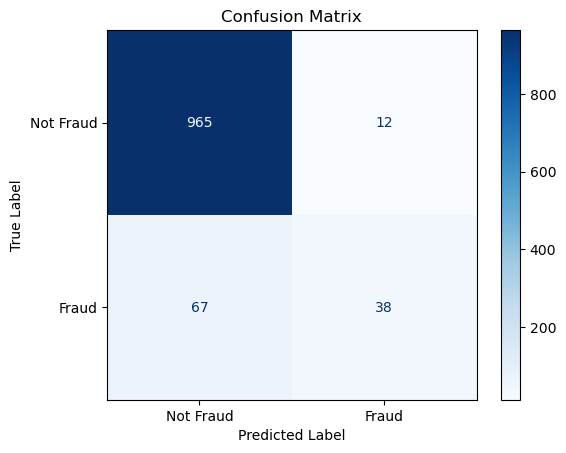

In [44]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Compute and display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

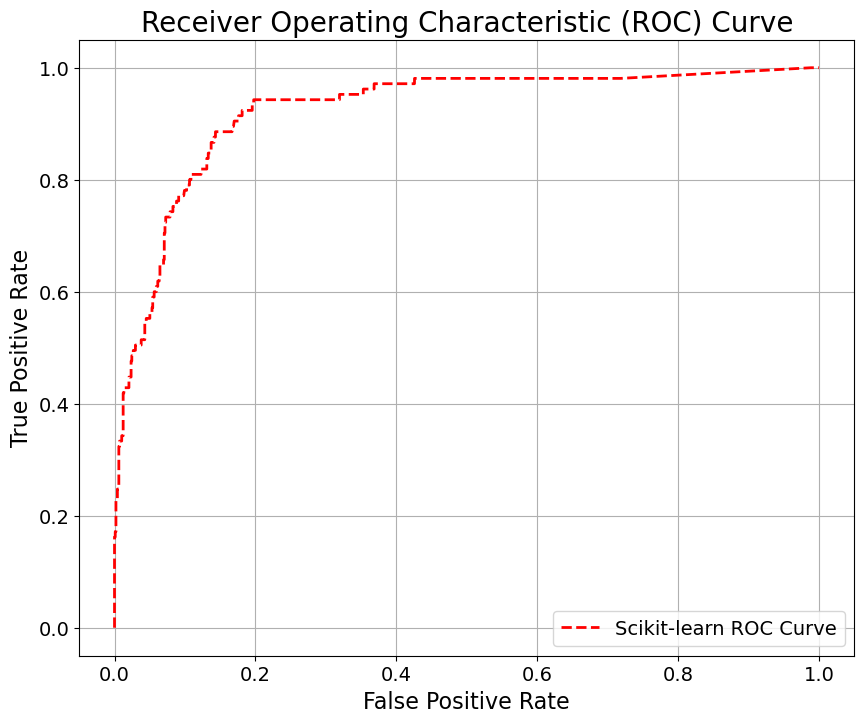

In [45]:
from sklearn.metrics import roc_curve

# Compare with scikit-learn's implementation
# Set up the figure first
fig, ax = plt.subplots(figsize=(10, 8))
# Compare with scikit-learn's implementation
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
# roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, 'r--', lw=2, label=f'Scikit-learn ROC Curve') #(AUC = {roc_auc:.2f})')
# Add styling with larger fonts
ax.set_title('Receiver Operating Characteristic (ROC) Curve', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=14)
ax.grid(True)

In [46]:
from sklearn.metrics import auc
# Area Under Curve
auc(fpr, tpr)

np.float64(0.9246039869376615)

In [168]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# Define Logistic Regression model
model = LogisticRegression(max_iter=1000)  # Increase max_iter for convergence

# Perform 5-fold cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')

# Print cross-validation results
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean accuracy: {cv_scores.mean():.4f}")


Cross-validation scores: [0.94085028 0.93992606 0.92421442 0.93438078 0.93068392]
Mean accuracy: 0.9340


## Hyperparameter Tuning Using `GridSearchCV`

In [169]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Regularization type
    'solver': ['liblinear', 'saga']  # Solvers that support L1 & L2
}

# Define logistic regression model
logreg = LogisticRegression(max_iter=1000)

# Perform GridSearchCV optimizing for recall
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='recall', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Display best parameters and recall score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Recall Score: {grid_search.best_score_:.4f}")


/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml_env/lib/python3.9/site-pack

Best Parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Best Recall Score: 0.4563


/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml_env/lib/python3.9/site-pack

In [170]:
from sklearn.metrics import classification_report

# Get the best trained model
best_model = grid_search.best_estimator_

# Predict on test set
y_pred = best_model.predict(X_test)

# Evaluate performance
report = classification_report(y_test, y_pred, target_names=['Not Fraud', 'Fraud'])
print(report)


              precision    recall  f1-score   support

   Not Fraud       0.94      0.99      0.96       977
       Fraud       0.76      0.36      0.49       105

    accuracy                           0.93      1082
   macro avg       0.85      0.67      0.73      1082
weighted avg       0.92      0.93      0.92      1082



In [171]:
# 4. Make predictions on the test set.
y_predict = best_model.predict(X_test)  # Outputs predicted class labels (0 or 1)

# 4a Make probability
y_proba = best_model.predict_proba(X_test)[:, 1]


In [172]:
from sklearn.metrics import confusion_matrix
# Assuming y_test contains true labels and y_predict contains predicted labels
cm = confusion_matrix(y_test, y_predict)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[965  12]
 [ 67  38]]


In [173]:
print(accuracy_score(y_test, y_predict))

0.9269870609981515


In [174]:
TN, FP, FN, TP = cm.ravel()
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f'{recall:.4f}')

0.3619


# Apply cross validation

In [47]:
X

,IPInscClaimAmtReimbursedSum,IPDeductibleAmtPaidSum,IPClmProcedureCode_1Nunique,OPDeductibleAmtPaidSum
0,97000.0,5340.0,2.0,0.0
1,573000.0,66216.0,32.0,70.0
2,0.0,0.0,0.0,310.0
3,0.0,0.0,0.0,3700.0
4,19000.0,3204.0,1.0,60.0
...,...,...,...,...
5405,0.0,0.0,0.0,130.0
5406,0.0,0.0,0.0,0.0
5407,0.0,0.0,0.0,370.0
5408,0.0,0.0,0.0,0.0


In [48]:
y

0       0
1       1
2       0
3       1
4       0
       ..
5405    0
5406    0
5407    0
5408    0
5409    0
Name: PotentialFraud, Length: 5410, dtype: int64

In [49]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# Define Logistic Regression model
model = LogisticRegression(max_iter=1000)  # Increase max_iter for convergence

# Perform 5-fold cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')

# Print cross-validation results
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean roc_auc: {cv_scores.mean():.4f}")


Cross-validation scores: [0.9524379  0.94227955 0.91774407 0.9216752  0.92322929]
Mean roc_auc: 0.9315


## Hyperparameter Tuning Using `GridSearchCV`

In [50]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Regularization type
    'solver': ['liblinear', 'saga']  # Solvers that support L1 & L2
}

# Define logistic regression model
logreg = LogisticRegression(max_iter=1000)

# Perform GridSearchCV optimizing for roc_auc
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Display best parameters and roc_auc score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Roc_Auc Score: {grid_search.best_score_:.4f}")


/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml_env/lib/python3.9/site-pack

Best Parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Best Roc_Auc Score: 0.9375


/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [51]:
from sklearn.metrics import classification_report

# Get the best trained model
best_model = grid_search.best_estimator_

# Predict on test set
y_pred = best_model.predict(X_test)

# Evaluate performance
report = classification_report(y_test, y_pred, target_names=['Not Fraud', 'Fraud'])
print(report)


              precision    recall  f1-score   support

   Not Fraud       0.94      0.99      0.96       977
       Fraud       0.76      0.37      0.50       105

    accuracy                           0.93      1082
   macro avg       0.85      0.68      0.73      1082
weighted avg       0.92      0.93      0.92      1082



In [52]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[965,  12],
       [ 66,  39]])

In [ ]:
# grid_search = GridSearchCV(model, param_grid, cv=5, scoring='recall', n_jobs=-1)


In [ ]:
# from sklearn.metrics import make_scorer, fbeta_score
# custom_scorer = make_scorer(fbeta_score, beta=2)


In [ ]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import make_scorer, fbeta_score
# from sklearn.linear_model import LogisticRegression

# # Define custom scorer (F-beta score with beta=2, which favors recall)
# custom_scorer = make_scorer(fbeta_score, beta=2)

# # Define hyperparameter grid
# param_grid = {
#     'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
#     'penalty': ['l1', 'l2'],  # Regularization type
#     'solver': ['liblinear', 'saga']  # Solvers that support L1 & L2
# }

# # Define logistic regression model
# model = LogisticRegression(max_iter=1000)

# # Use GridSearchCV with the custom scorer
# grid_search = GridSearchCV(model, param_grid, cv=5, scoring=custom_scorer, n_jobs=-1)
# grid_search.fit(X_train, y_train)

# # Print the best parameters & best F-beta score
# print(f"Best Parameters: {grid_search.best_params_}")
# print(f"Best F2 Score: {grid_search.best_score_:.4f}")


Best Parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Best F2 Score: 0.4843


In [53]:
final_df.head()

,Provider,IPInscClaimAmtReimbursedNunique,IPInscClaimAmtReimbursedMean,IPInscClaimAmtReimbursedStd,IPInscClaimAmtReimbursedSum,IPDeductibleAmtPaidMean,IPDeductibleAmtPaidStd,IPDeductibleAmtPaidSum,IPClmProcedureCode_1Nunique,IPClmProcedureCode_1Count,IPClmProcedureCode_2Nunique,IPClmProcedureCode_2Count,IPClmProcedureCode_3Nunique,IPClmProcedureCode_3Count,IPClmProcedureCode_4Nunique,IPClmProcedureCode_4Count,IPClmProcedureCode_5Nunique,IPClmProcedureCode_5Count,IPClmProcedureCode_6Nunique,IPClmProcedureCode_6Count,OPInscClaimAmtReimbursedNunique,OPInscClaimAmtReimbursedMean,OPInscClaimAmtReimbursedStd,OPInscClaimAmtReimbursedSum,OPDeductibleAmtPaidMean,OPDeductibleAmtPaidStd,OPDeductibleAmtPaidSum,OPClmProcedureCode_1Nunique,OPClmProcedureCode_1Count,OPClmProcedureCode_2Nunique,OPClmProcedureCode_2Count,OPClmProcedureCode_3Nunique,OPClmProcedureCode_3Count,OPClmProcedureCode_4Nunique,OPClmProcedureCode_4Count,OPClmProcedureCode_5Nunique,OPClmProcedureCode_5Count,OPClmProcedureCode_6Nunique,OPClmProcedureCode_6Count,PotentialFraud
0,PRV51001,5.0,19400.000000,18352.111595,97000.0,1068.0,0.0,5340.0,2.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,382.000000,422.817617,7640.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,PRV51003,18.0,9241.935484,8513.606244,573000.0,1068.0,0.0,66216.0,32.0,39.0,7.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,466.714286,821.364579,32670.0,1.000000,8.366600,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,PRV51004,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,350.134228,689.963754,52170.0,2.080537,11.166744,310.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,PRV51005,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.0,241.124464,491.556392,280910.0,3.175966,17.026584,3700.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,PRV51007,3.0,6333.333333,3511.884584,19000.0,1068.0,0.0,3204.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,213.188406,447.231657,14710.0,0.869565,6.121114,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [54]:
X

,IPInscClaimAmtReimbursedSum,IPDeductibleAmtPaidSum,IPClmProcedureCode_1Nunique,OPDeductibleAmtPaidSum
0,97000.0,5340.0,2.0,0.0
1,573000.0,66216.0,32.0,70.0
2,0.0,0.0,0.0,310.0
3,0.0,0.0,0.0,3700.0
4,19000.0,3204.0,1.0,60.0
...,...,...,...,...
5405,0.0,0.0,0.0,130.0
5406,0.0,0.0,0.0,0.0
5407,0.0,0.0,0.0,370.0
5408,0.0,0.0,0.0,0.0


In [55]:
y

0       0
1       1
2       0
3       1
4       0
       ..
5405    0
5406    0
5407    0
5408    0
5409    0
Name: PotentialFraud, Length: 5410, dtype: int64

In [56]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# # Define features (X) and target (y)
# X = final_df.drop(columns=['Provider','PotentialFraud'])
# y = final_df['PotentialFraud']

# Split data into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check class distribution after SMOTE
print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_resampled.value_counts())


Before SMOTE: PotentialFraud
0    3923
1     405
Name: count, dtype: int64
After SMOTE: PotentialFraud
0    3923
1    3923
Name: count, dtype: int64


/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [57]:
model_after_smote = LogisticRegression(max_iter=1000)
model_after_smote.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=1000)

In [58]:
# from sklearn.metrics import classification_report

# Predict on the test set (original imbalanced data)
y_pred = model_after_smote.predict(X_test)
y_proba = model_after_smote.predict_proba(X_test)[:, 1] # predict probabilities, what's closer to 0 or 1.


In [59]:
from sklearn.metrics import confusion_matrix
# Assuming y_test contains true labels and y_predict contains predicted labels
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[887  94]
 [ 14  87]]


In [60]:
# print('Confusion Matrix before manipulating by adding the threshold:\n')
# cm = confusion_matrix(y_test, y_pred)

# flatten the confusion matrix and break it down into four components.
TN, FP, FN, TP = cm.ravel()
# Calculating metrics
accuracy = accuracy_score(y_test, y_pred) # 2 ways to calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN) # Proportion of correct predictions
print(f'Accuracy: {accuracy:.2f}')
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
print(f'Precision: {precision:.2f}')
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f'Recall: {recall:.2f}')
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print(f'F1 Score: {f1_score:.2f}')

Accuracy: 0.90
Precision: 0.48
Recall: 0.86
F1 Score: 0.62


In [61]:
from sklearn.metrics import roc_auc_score

y_proba = model_after_smote.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class (fraud)
auc_score = roc_auc_score(y_test, y_proba)

print(f"ROC-AUC Score: {auc_score:.4f}")


ROC-AUC Score: 0.9492


In [62]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  
    'penalty': ['l1', 'l2'],  
    'solver': ['liblinear', 'saga']
}

# Use GridSearchCV to optimize for recall
grid_search = GridSearchCV(model_after_smote, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best model
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)


/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml_env/lib/python3.9/site-pack

Best Parameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}


/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [63]:
from sklearn.metrics import roc_auc_score

y_proba = best_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class (fraud)
auc_score = roc_auc_score(y_test, y_proba)

print(f"ROC-AUC Score: {auc_score:.4f}")


ROC-AUC Score: 0.9490


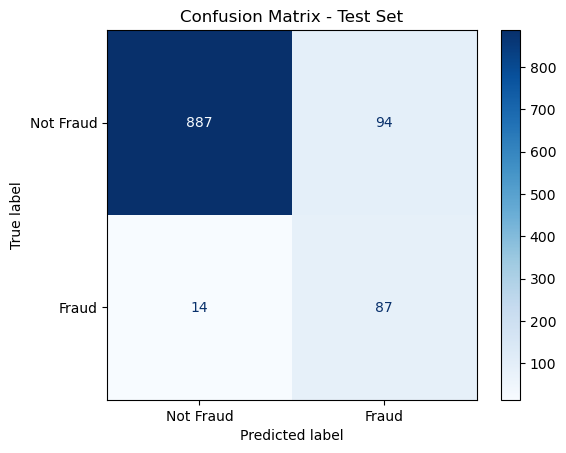

In [64]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Test Set")
plt.show()


In [65]:
from sklearn.metrics import confusion_matrix
# Assuming y_test contains true labels and y_predict contains predicted labels
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[887  94]
 [ 14  87]]


In [66]:
# flatten the confusion matrix and break it down into four components.
TN, FP, FN, TP = cm.ravel()
print('Confusion Matrix before manipulating by adding the threshold:\n')
# Calculating metrics
accuracy = accuracy_score(y_test, y_pred) # 2 ways to calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN) # Proportion of correct predictions
print(f'Accuracy: {accuracy:.2f}')
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
print(f'Precision: {precision:.2f}')
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f'Recall: {recall:.2f}')
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print(f'F1 Score: {f1_score:.2f}')

Confusion Matrix before manipulating by adding the threshold:

Accuracy: 0.90
Precision: 0.48
Recall: 0.86
F1 Score: 0.62
